# New Model Thinking

Moving to a Linear Regression model

Previously I constructed a Classification model to predict whether a dog would win a race or not.  However, this proved troublesome as each dog races against 4 or 5 other dogs and it is hard to teach the model to only consider those 5 other dogs as opposed to the rest of the information in my dataset.

Therefore a different philosophy is being considered.  This time I shall estimate the running time of each dog for that point in time.  Then we can loop through the Race ids and compare and rank each dog in that race in an attempt to find a winner.

First must load packages and a dataset to try things out on.

In [120]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sqlalchemy import create_engine
engine = create_engine('postgresql://localhost:5432/danielpayne')

In [121]:
from sklearn.linear_model import BayesianRidge, LinearRegression
import patsy
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

In [122]:
hounds = pd.read_sql("SELECT * FROM feature_gbgb_data_sep_dec;", engine)
hounds.head()

,Date_time,index,born,comment,dam,date,datetime,distance,going_allowance,grade,...,hour,year,male,winner,month,form_3,form_5,form_pos_3,form_pos_5,trend_3
0,2016-09-01 11:03:00+01:00,69922,2015-01-01,Crd2,Bradgate Star,01/09/16,11:03,450.0,0.0,A5,...,11,2016,1,0,9,0.0,0.0,0.0,0.0,0.0
1,2016-09-01 11:03:00+01:00,69921,2015-04-01,Crd2,Ballymac Sue,01/09/16,11:03,450.0,0.0,A5,...,11,2016,0,0,9,0.0,0.0,0.0,0.0,0.0
2,2016-09-01 11:03:00+01:00,69920,2014-07-01,Bmp2,Larkhill Kitten,01/09/16,11:03,450.0,0.0,A5,...,11,2016,1,0,9,0.0,0.0,0.0,0.0,0.0
3,2016-09-01 11:03:00+01:00,69919,2012-11-01,"EP,Bmp2",Caulry Pearl,01/09/16,11:03,450.0,0.0,A5,...,11,2016,0,0,9,0.0,0.0,0.0,0.0,0.0
4,2016-09-01 11:03:00+01:00,69918,2014-03-01,EvCh,Crafty Bonito,01/09/16,11:03,450.0,0.0,A5,...,11,2016,1,0,9,0.0,0.0,0.0,0.0,0.0


In [123]:
hounds = hounds.drop('index', axis = 1)
hounds.head(2)

,Date_time,born,comment,dam,date,datetime,distance,going_allowance,grade,name,...,hour,year,male,winner,month,form_3,form_5,form_pos_3,form_pos_5,trend_3
0,2016-09-01 11:03:00+01:00,2015-01-01,Crd2,Bradgate Star,01/09/16,11:03,450.0,0.0,A5,Lahana Star,...,11,2016,1,0,9,0.0,0.0,0.0,0.0,0.0
1,2016-09-01 11:03:00+01:00,2015-04-01,Crd2,Ballymac Sue,01/09/16,11:03,450.0,0.0,A5,Ballymac Thelma,...,11,2016,0,0,9,0.0,0.0,0.0,0.0,0.0


In [124]:
# Take out zero values
print hounds.shape
mask = (hounds.time == 0)
hounds = hounds[~mask]
hounds.shape

(35937, 38)


(35532, 38)

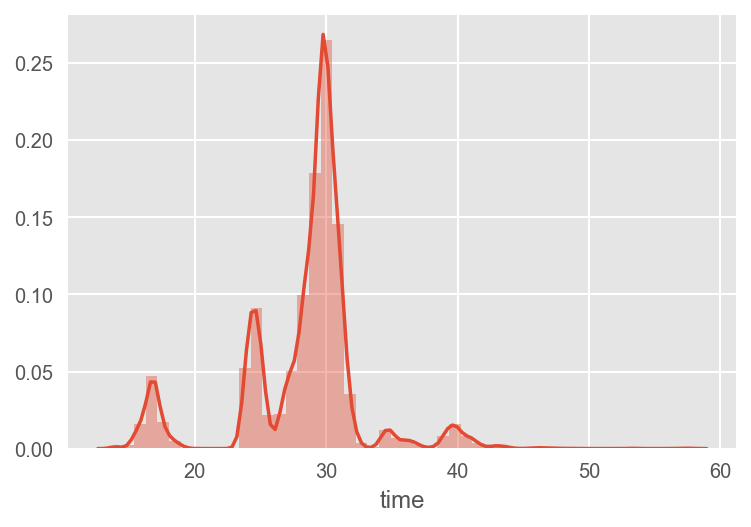

In [110]:
# Look at distribution of time values
sns.distplot(hounds.time)

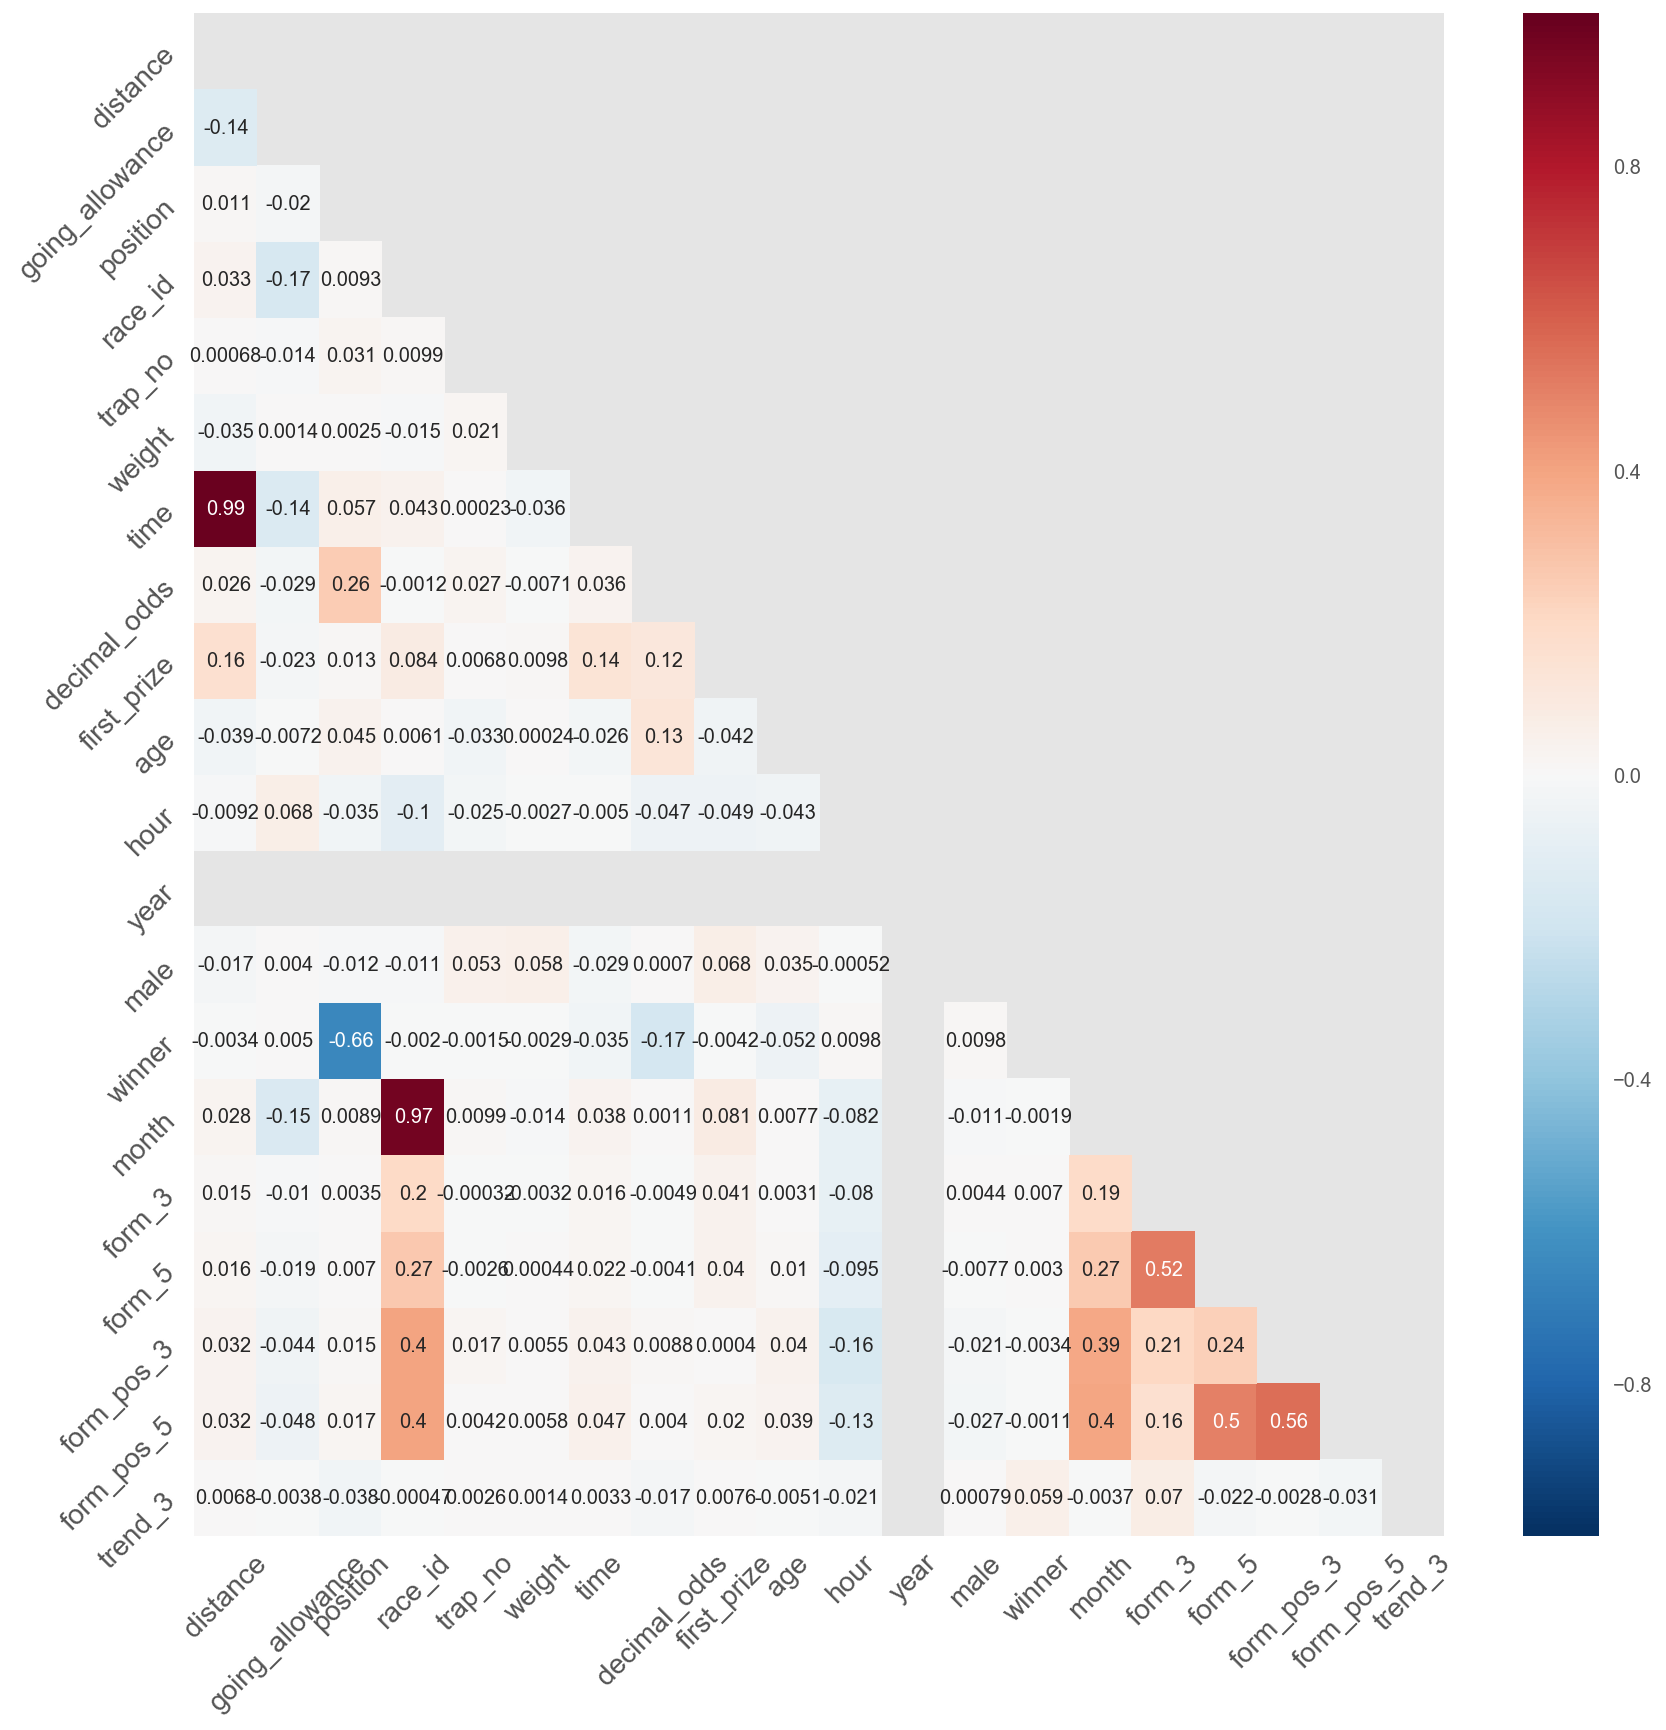

In [43]:
# Look at heatmap
corr = hounds.corr()

fig, ax = plt.subplots(figsize=(14,14))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, mask=mask, ax=ax, annot = True)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=45)

plt.show()

As time was limited, I wanted to see if the overall structure of my new model worked so I tested this on a small part of the dataset.

In [125]:
# Test the model on part of the dataset

dogs = hounds.loc[hounds.distance == 480]
print dogs.shape, hounds.shape

(11193, 38) (35532, 38)


In [ ]:
# There are some columns where the information will not be available beforehand.  I will remove these from the model

cols_to_remove = ['Time', 'Position', 'Time_trap', 'Time_distance', 'Prizes', 'Date_time', 'age'
                  'Odds','Comment', 'Date', 'Winner', 'Datetime', 'Random', 'Born', 'Year', 'day', 'distance', 'dam', 'sire']
cols_to_remove = [f.lower() for f in cols_to_remove]
cols_to_remove = cols_to_remove + ['Date_time']
cols_to_model = [c for c in dogs.columns if c not in cols_to_remove]

In [181]:
# Use Patsy to make design matrices
formula  =  "time ~ " + ' + '.join(cols_to_model) + '-1'

y, X     =  patsy.dmatrices(formula, data=dogs, return_type="dataframe")

# Check shape of features and targets as well as Years column
print X.shape, y.shape

(11193, 3464) (11193, 1)


In [183]:
# Split the data in training and test sets. 
X['month'] = dogs['month']
y['month'] = dogs['month']

X_train = X.loc[X.month != 12]
X_test = X.loc[X.month == 12]
y_train = y.loc[y.month != 12]
y_test = y.loc[y.month == 12]

X_train.drop('month', axis=1, inplace=True)
X_test.drop('month', axis=1, inplace=True)

/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [184]:
# Make target as a 1-d array

y_train = y_train.time.values
y_test = y_test.time.values

print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(8185, 3463) (3008, 3463) (8185,) (3008,)


In [185]:
# Linear Regression model
lm = LinearRegression()

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

Score: 0.459029962832


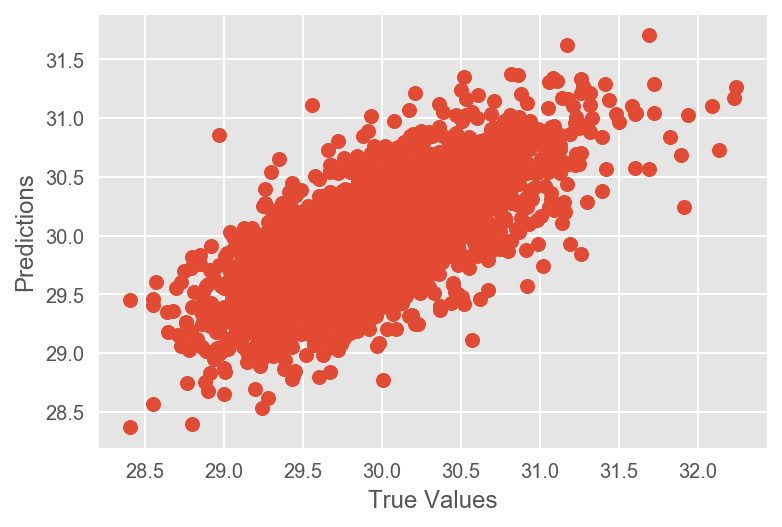

In [186]:
## The line / model
plt.scatter(y_test, predictions)
#plt.plot(np.linspace(0,50,200),np.linspace(0,50,200),c='r',lw=2)
plt.xlabel("True Values")
plt.ylabel("Predictions")

print "Score:", model.score(X_test, y_test)

Although there is a poor R2 score you can see a linear relationship between predicted times and true times. 

This is an encouraging sign.  I will look at which co-efficients are the most prevalent

In [201]:
#Co-efficients table
coef_table = pd.DataFrame({'Co-efficients' : model.coef_,
                          'Feature' : X.columns[:-1],
                          'Abs_coeffs' : np.abs(model.coef_)})
coef_table.sort_values(by='Co-efficients', inplace=True)
coef_table.head()

,Abs_coeffs,Co-efficients,Feature
2693,17.082724,-17.082724,name[T.Suirview Maya]
3441,5.851434,-5.851434,trainer[T.T Hudson]
82,1.188929,-1.188929,name[T.Airport Jumbo]
1828,1.147284,-1.147284,name[T.Mash Mad Lottie]
2010,1.101144,-1.101144,name[T.Newinn Hammer]


In [207]:
coef_ht = pd.concat([coef_table.head(), coef_table.tail()], axis=0)
coef_ht.reset_index(inplace=True)
coef_ht

,index,Abs_coeffs,Co-efficients,Feature
0,2693,17.082724,-17.082724,name[T.Suirview Maya]
1,3441,5.851434,-5.851434,trainer[T.T Hudson]
2,82,1.188929,-1.188929,name[T.Airport Jumbo]
3,1828,1.147284,-1.147284,name[T.Mash Mad Lottie]
4,2010,1.101144,-1.101144,name[T.Newinn Hammer]
5,324,1.902083,1.902083,name[T.Barranca Billy]
6,3120,1.999106,1.999106,name[T.Ziggys Return]
7,142,2.076395,2.076395,name[T.Ardera Spirit]
8,1770,5.607045,5.607045,name[T.Madabout Susie]
9,2837,5.624245,5.624245,name[T.This Time]


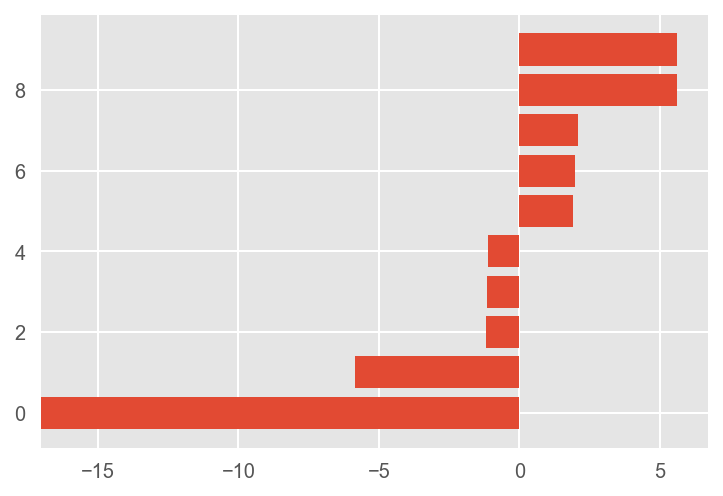

In [212]:
plt.barh(coef_ht.index, coef_ht['Co-efficients'], label = coef_ht.Feature)
plt.show()

**Now I will look at the distribution of predicted times and use them to add into the table to rank them and use for classification**

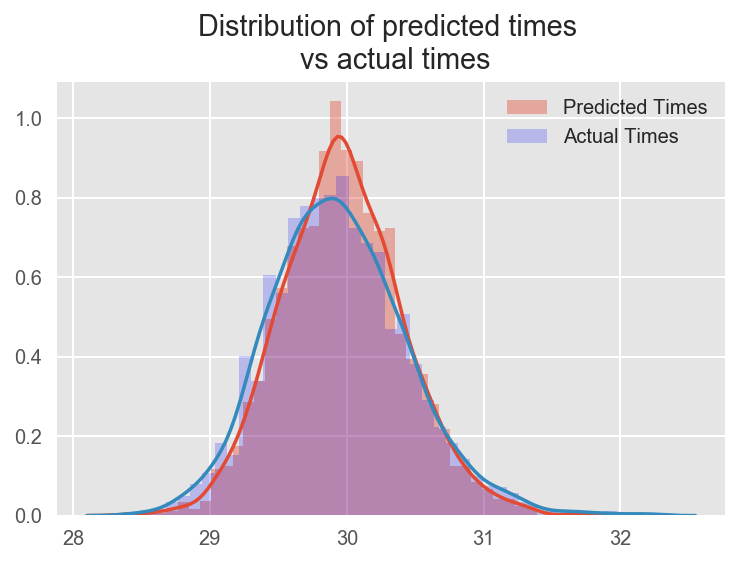

In [217]:
# Look at the distribution of predicted times and actual times
sns.distplot(predictions, label = 'Predicted Times')
sns.distplot(y_test, hist_kws={"linewidth": 3,
                               "alpha": 0.2, "color": "b"}, label = 'Actual Times')
plt.title('Distribution of predicted times \n vs actual times')
plt.legend(loc='upper right')
plt.show()

In [218]:
# Now look to to add predicted times into the test dataframe and rank each dog by time by race...

dogs_test = dogs.loc[dogs.month == 12]
dogs_test['predicted_time'] = predictions
dogs_test.head()

/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Date_time,born,comment,dam,date,datetime,distance,going_allowance,grade,name,...,year,male,winner,month,form_3,form_5,form_pos_3,form_pos_5,trend_3,predicted_time
25924,2016-12-02 10:38:00+00:00,2012-04-01,"Rls,SAw",Runaroundangel,02/12/16,10:38,480.0,20.0,A8,Drunk In Love,...,2016,1,0,12,0.000000,0.0,3.000000,4.2,-0.333333,30.451006
25925,2016-12-02 10:38:00+00:00,2011-08-01,"W,ClrRun",Lady Bluebell,02/12/16,10:38,480.0,20.0,A8,Roseville Power,...,2016,1,0,12,0.333333,0.0,2.333333,0.0,0.000000,30.126638
25926,2016-12-02 10:38:00+00:00,2013-09-01,"Mid,SAw",Katies Lass,02/12/16,10:38,480.0,20.0,A8,Peaky Blinder,...,2016,1,0,12,0.000000,0.0,4.000000,4.2,-0.333333,30.508724
25927,2016-12-02 10:38:00+00:00,2013-11-01,"Rls,SAw",Finnery Bret,02/12/16,10:38,480.0,20.0,A8,Finnery Ace,...,2016,0,0,12,0.000000,0.0,5.666667,0.0,0.333333,30.496299
25928,2016-12-02 10:38:00+00:00,2012-07-01,"W,ClrRun",Cashen Shadow,02/12/16,10:38,480.0,20.0,A8,Clonleigh Kate,...,2016,0,0,12,0.333333,0.2,2.333333,3.6,0.000000,30.276746


In [219]:
# Make a neater table for this part.
dogs_te = dogs_test[['race_id', 'date_time', 'name', 'track', 'grade', 'time', 'predicted_time', 'winner', 'position']]
dogs_te.head(12)

,race_id,date_time,name,track,grade,time,predicted_time,winner,position
25924,1935168.0,2016-12-02 10:38:00,Drunk In Love,Swindon,A8,30.39,30.451006,0,6.0
25925,1935168.0,2016-12-02 10:38:00,Roseville Power,Swindon,A8,30.31,30.126638,0,5.0
25926,1935168.0,2016-12-02 10:38:00,Peaky Blinder,Swindon,A8,30.21,30.508724,0,4.0
25927,1935168.0,2016-12-02 10:38:00,Finnery Ace,Swindon,A8,30.15,30.496299,0,3.0
25928,1935168.0,2016-12-02 10:38:00,Clonleigh Kate,Swindon,A8,29.79,30.276746,0,2.0
25929,1935168.0,2016-12-02 10:38:00,Oakfield Dream,Swindon,A8,29.72,30.535370,1,1.0
25936,1935169.0,2016-12-02 10:53:00,Bale Again,Swindon,A5,29.90,29.678028,0,6.0
25937,1935169.0,2016-12-02 10:53:00,Saucy Rumble,Swindon,A5,29.83,30.068478,0,5.0
25938,1935169.0,2016-12-02 10:53:00,Alarming Khaos,Swindon,A5,29.75,29.958274,0,4.0
25939,1935169.0,2016-12-02 10:53:00,Clover Flair,Swindon,A5,29.74,29.866071,0,3.0


**Test a function for ranking the dogs times**

In [220]:
test_df = dogs_te.loc[dogs_te.race_id == 1935169]
test_df

,race_id,date_time,name,track,grade,time,predicted_time,winner,position
25936,1935169.0,2016-12-02 10:53:00,Bale Again,Swindon,A5,29.90,29.678028,0,6.0
25937,1935169.0,2016-12-02 10:53:00,Saucy Rumble,Swindon,A5,29.83,30.068478,0,5.0
25938,1935169.0,2016-12-02 10:53:00,Alarming Khaos,Swindon,A5,29.75,29.958274,0,4.0
25939,1935169.0,2016-12-02 10:53:00,Clover Flair,Swindon,A5,29.74,29.866071,0,3.0
25940,1935169.0,2016-12-02 10:53:00,Suirview Royal,Swindon,A5,29.69,30.024968,0,2.0
25941,1935169.0,2016-12-02 10:53:00,Dromana Blonde,Swindon,A5,29.51,29.678098,1,1.0


In [222]:
test_df['pred_position'] = test_df.predicted_time.rank()
test_df['pred_winner'] = test_df.pred_position.map(lambda x: 1 if x == 1 else 0)
test_df

/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,race_id,date_time,name,track,grade,time,predicted_time,winner,position,pred_position,pred_winner
25936,1935169.0,2016-12-02 10:53:00,Bale Again,Swindon,A5,29.90,29.678028,0,6.0,1.0,1
25937,1935169.0,2016-12-02 10:53:00,Saucy Rumble,Swindon,A5,29.83,30.068478,0,5.0,6.0,0
25938,1935169.0,2016-12-02 10:53:00,Alarming Khaos,Swindon,A5,29.75,29.958274,0,4.0,4.0,0
25939,1935169.0,2016-12-02 10:53:00,Clover Flair,Swindon,A5,29.74,29.866071,0,3.0,3.0,0
25940,1935169.0,2016-12-02 10:53:00,Suirview Royal,Swindon,A5,29.69,30.024968,0,2.0,5.0,0
25941,1935169.0,2016-12-02 10:53:00,Dromana Blonde,Swindon,A5,29.51,29.678098,1,1.0,2.0,0


In [308]:
# Define function

def predict_pos(race, df): 
    test_df = df.loc[df.race_id == race]
    test_df['pred_position'] = test_df.predicted_time.rank()
    return test_df['pred_position']
predict_pos(1935168, dogs_te)

/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


25924    3.0
25925    1.0
25926    5.0
25927    4.0
25928    2.0
25929    6.0
Name: pred_position, dtype: float64

In [235]:
pred_pos = pd.Series()
for race in dogs_te.race_id.unique():
    pred_pos = pred_pos.append(predict_pos(race))

/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [238]:
dogs_te['pred_position'] = pred_pos
dogs_te['pred_winner'] = dogs_te.pred_position.map(lambda x: 1 if x == 1 else 0)
dogs_te.head()

/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,race_id,date_time,name,track,grade,time,predicted_time,winner,position,pred_position,pred_winner
25924,1935168.0,2016-12-02 10:38:00,Drunk In Love,Swindon,A8,30.39,30.451006,0,6.0,3.0,0
25925,1935168.0,2016-12-02 10:38:00,Roseville Power,Swindon,A8,30.31,30.126638,0,5.0,1.0,1
25926,1935168.0,2016-12-02 10:38:00,Peaky Blinder,Swindon,A8,30.21,30.508724,0,4.0,5.0,0
25927,1935168.0,2016-12-02 10:38:00,Finnery Ace,Swindon,A8,30.15,30.496299,0,3.0,4.0,0
25928,1935168.0,2016-12-02 10:38:00,Clonleigh Kate,Swindon,A8,29.79,30.276746,0,2.0,2.0,0


In [239]:
# Function to plot a confusion matrix

import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

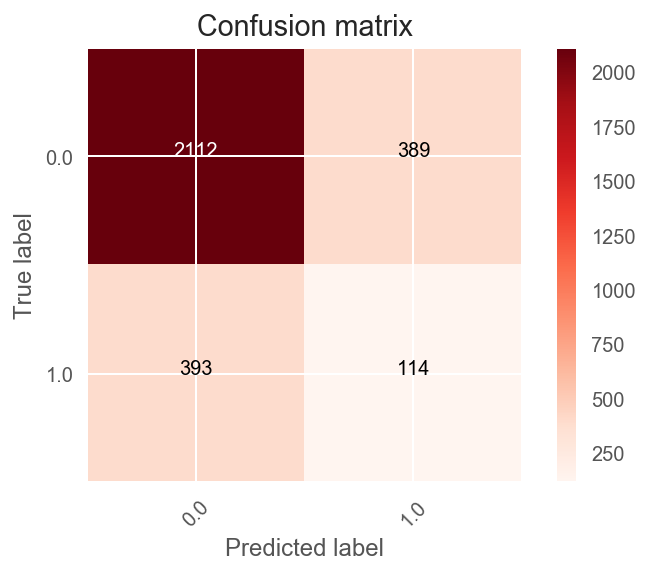

In [241]:
from sklearn import metrics
conmat = metrics.confusion_matrix(dogs_te.winner.values, dogs_te.pred_winner.values)
classes = np.array([ 0.,  1.])
plot_confusion_matrix(conmat, classes)

In [242]:
class_report = metrics.classification_report(dogs_te.winner.values, dogs_te.pred_winner.values)
print class_report

             precision    recall  f1-score   support

          0       0.84      0.84      0.84      2501
          1       0.23      0.22      0.23       507

avg / total       0.74      0.74      0.74      3008



In [244]:
lm_vanilla_score = metrics.accuracy_score(dogs_te.winner.values, dogs_te.pred_winner.values)
print 'Linear Model Score:', lm_vanilla_score

Linear Model Score: 0.740026595745


Although the accuracy score was lower than the baseline score of 0.827, this does performa better than the logistic regression model.  This is encouraging.

I shall now adopt a similar approach and engineer a feature to tune the model further.

I will calculate the **mean time over the last 3 races..**

In [246]:
# write a function to calculate rolling mean time 
def time_form(dog_name, races):
    df = dogs.loc[dogs['name'] == dog_name]
    df['mean_time'] = df['time'].rolling(window = races, center=False).mean()
    return df.mean_time
time_form('Peaky Blinder', 3)

/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


161            NaN
1990           NaN
5441     30.316667
7896     31.000000
10947    31.120000
23228    31.126667
25201    30.600000
25926    30.440000
33581    30.250000
Name: mean_time, dtype: float64

In [247]:
# Create a series object for form of last 3 races that I can add onto Dataframe
time_form_3 = pd.Series()
for dog in dogs.name.unique():
    time_form_3 = time_form_3.append(time_form(dog, 3))

/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [250]:
# Check Null values
time_form_3.isnull().sum()

5370

In [252]:
# Append onto dataframe
dogs['mean_time_3'] = time_form_3
dogs.head()

/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Date_time,born,comment,dam,date,datetime,distance,going_allowance,grade,name,...,year,male,winner,month,form_3,form_5,form_pos_3,form_pos_5,trend_3,mean_time_3
65,2016-09-02 10:38:00+01:00,2014-06-01,"Rls,QAw,Crd3,(ReQul)",Kielduff West,02/09/16,10:38,480.0,-10.0,A8,Lilly The Lace,...,2016,0,0,9,0.0,0.0,0.0,0.0,0.0,NaN
66,2016-09-02 10:38:00+01:00,2010-02-01,"Wide,ChlFr4",Dark Lynn,02/09/16,10:38,480.0,-10.0,A8,Uncle Donal,...,2016,1,0,9,0.0,0.0,0.0,0.0,0.0,NaN
67,2016-09-02 10:38:00+01:00,2013-11-01,"Rls,Crd4,RanOn",Crab Lane Lass,02/09/16,10:38,480.0,-10.0,A8,Mohican Ennis,...,2016,0,0,9,0.0,0.0,0.0,0.0,0.0,NaN
68,2016-09-02 10:38:00+01:00,2013-07-01,"Wide,RanOn",Ballyboy Venture,02/09/16,10:38,480.0,-10.0,A8,Lisnakill Venus,...,2016,0,0,9,0.0,0.0,0.0,0.0,0.0,NaN
69,2016-09-02 10:38:00+01:00,2013-04-01,"Mid,VSAw,LedNrLn",Barro Babe,02/09/16,10:38,480.0,-10.0,A8,Barro Belle,...,2016,0,1,9,0.0,0.0,0.0,0.0,0.0,NaN


### A note on null values

For this experiment, I wanted to impute the null values for this column as I wanted the value to be close to what the epxected result is.

This will produce some outliers but time constraints mena that I can't deal with this thoroughly for now.

This is just a demonstration that the methodology works...

In [272]:
# Fill Mean time with the actual time so to have a value close to the expected mean time number.
dogs['mean_test'] = dogs['mean_test'].fillna(dogs.time)
dogs.tail()

/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Date_time,born,comment,dam,date,datetime,distance,going_allowance,grade,name,...,male,winner,month,form_3,form_5,form_pos_3,form_pos_5,trend_3,mean_time_3,mean_test
35932,2016-12-31 11:13:00+00:00,2014-09-01,"Rails,EvCh,(8)",Kilrush Kelly,31/12/16,11:13,480.0,-30.0,A7,Leighlin Ted,...,1,0,12,0.000000,0.0,2.666667,0.0,0.333333,NaN,29.800000
35933,2016-12-31 11:13:00+00:00,2013-08-01,"BCrd1,(8)",Elegant Helen,31/12/16,11:13,480.0,-30.0,A7,Dunbar Linda,...,0,0,12,0.000000,0.0,0.000000,0.0,0.000000,29.756667,29.756667
35934,2016-12-31 11:13:00+00:00,2015-05-01,"Led3ToNrLn,(8)",Swift Eva,31/12/16,11:13,480.0,-30.0,A7,Swift Cody,...,1,0,12,0.333333,0.2,3.333333,4.6,-0.333333,29.320000,29.320000
35935,2016-12-31 11:13:00+00:00,2013-08-01,"EP,LedTo3,CmAg,(8)",Head Iton Tina,31/12/16,11:13,480.0,-30.0,A7,Head Iton Carl,...,1,1,12,0.000000,0.0,5.000000,0.0,0.000000,29.653333,29.653333
35936,2016-12-31 11:13:00+00:00,2014-10-01,"VSAw,Crd1,(8)",Windmill Daisey,31/12/16,11:13,480.0,-30.0,A7,Lilly Lilly,...,0,0,12,0.333333,0.2,4.666667,4.6,0.000000,30.033333,30.033333


In [ ]:
# There are some columns where the information will not be available beforehand.  I will remove these from the model

cols_to_remove = ['Time', 'Position', 'Time_trap', 'Time_distance', 'Prizes', 'Date_time', 'age', 'mean_time_3',
                  'Odds','Comment', 'Date', 'Winner', 'Datetime', 'Random', 'Born', 'Year', 'day', 'distance', 'dam', 'sire']
cols_to_remove = [f.lower() for f in cols_to_remove]
cols_to_remove = cols_to_remove + ['Date_time']
cols_to_model = [c for c in dogs.columns if c not in cols_to_remove]


In [275]:
# Use Patsy to make design matrices
formula  =  "time ~ " + ' + '.join(cols_to_model) + '-1'

y, X     =  patsy.dmatrices(formula, data=dogs, return_type="dataframe")

# Check shape of features and targets as well as Years column
print X.shape, y.shape

(11193, 3399) (11193, 1)


In [276]:
X['month'] = dogs['month']
y['month'] = dogs['month']

X_train = X.loc[X.month != 12]
X_test = X.loc[X.month == 12]
y_train = y.loc[y.month != 12]
y_test = y.loc[y.month == 12]

X_train.drop('month', axis=1, inplace=True)
X_test.drop('month', axis=1, inplace=True)

/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [277]:
# Make target as a 1-d array

y_train = y_train.time.values
y_test = y_test.time.values

print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(8185, 3398) (3008, 3398) (8185,) (3008,)


In [278]:
lm = LinearRegression()

model1 = lm.fit(X_train, y_train)
predictions1 = lm.predict(X_test)

Score: -42123113331.9


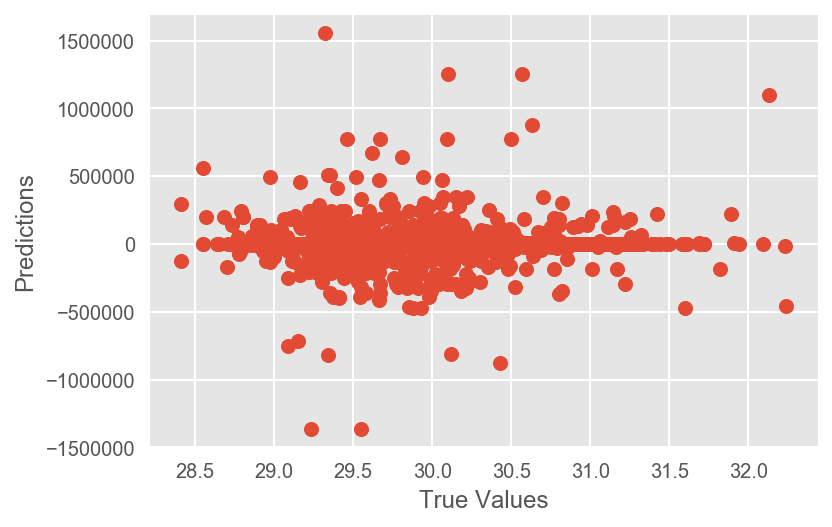

In [279]:
## The line / model
plt.scatter(y_test, predictions1)
#plt.plot(np.linspace(0,50,200),np.linspace(0,50,200),c='r',lw=2)
plt.xlabel("True Values")
plt.ylabel("Predictions")

print "Score:", model1.score(X_test, y_test)

FRom the graph above, as expected, there are some values that are extreme caused by the imputed values.

I shall remove them to examine if a linear relationship exists...

In [281]:
coef_table1 = pd.DataFrame({'Co-efficients' : model1.coef_,
                          'Feature' : X.columns[:-1],
                          'Abs_coeffs' : np.abs(model1.coef_)})
coef_table1.sort_values(by='Co-efficients', inplace=True)
coef_table1.head()

,Abs_coeffs,Co-efficients,Feature
341,1.194802e+06,-1.194802e+06,name[T.Beatties Midget]
3180,1.140562e+06,-1.140562e+06,trainer[T.D E Fradgley]
1315,1.096915e+06,-1.096915e+06,name[T.Hazy Miranda]
1612,1.096915e+06,-1.096915e+06,name[T.Kilpedder Impact]
2648,1.053638e+06,-1.053638e+06,name[T.Stouke Scorpio]


In [285]:
coef_table1.tail()

,Abs_coeffs,Co-efficients,Feature
3266,7.362258e+05,7.362258e+05,trainer[T.K J O'Hara]
3286,8.565344e+05,8.565344e+05,trainer[T.M W Jeans]
130,9.309352e+05,9.309352e+05,name[T.Apostle]
235,1.257523e+06,1.257523e+06,name[T.Ballyhi Katie]
79,1.558838e+06,1.558838e+06,name[T.Airmount Bride]


In [310]:
dogs_test1 = dogs.loc[dogs.month == 12]
dogs_test1['predicted_time'] = predictions1
dogs_test1.head()

/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Date_time,born,comment,dam,date,datetime,distance,going_allowance,grade,name,...,winner,month,form_3,form_5,form_pos_3,form_pos_5,trend_3,mean_time_3,mean_test,predicted_time
25924,2016-12-02 10:38:00+00:00,2012-04-01,"Rls,SAw",Runaroundangel,02/12/16,10:38,480.0,20.0,A8,Drunk In Love,...,0,12,0.000000,0.0,3.000000,4.2,-0.333333,30.610000,30.610000,30.486663
25925,2016-12-02 10:38:00+00:00,2011-08-01,"W,ClrRun",Lady Bluebell,02/12/16,10:38,480.0,20.0,A8,Roseville Power,...,0,12,0.333333,0.0,2.333333,0.0,0.000000,30.386667,30.386667,30.175313
25926,2016-12-02 10:38:00+00:00,2013-09-01,"Mid,SAw",Katies Lass,02/12/16,10:38,480.0,20.0,A8,Peaky Blinder,...,0,12,0.000000,0.0,4.000000,4.2,-0.333333,30.440000,30.440000,30.397725
25927,2016-12-02 10:38:00+00:00,2013-11-01,"Rls,SAw",Finnery Bret,02/12/16,10:38,480.0,20.0,A8,Finnery Ace,...,0,12,0.000000,0.0,5.666667,0.0,0.333333,30.380000,30.380000,30.118962
25928,2016-12-02 10:38:00+00:00,2012-07-01,"W,ClrRun",Cashen Shadow,02/12/16,10:38,480.0,20.0,A8,Clonleigh Kate,...,0,12,0.333333,0.2,2.333333,3.6,0.000000,30.223333,30.223333,30.113097


Create a mask and remove the outliers...

In [311]:
# Mask
pred_mask = ((dogs_test1.predicted_time > 40) | (dogs_test1.predicted_time < 20))

In [312]:
# A table with predicted times under 40 seconds and over 20 seconds.  An expected time for this distance.
dogs_under_40 = dogs_test1[~pred_mask]

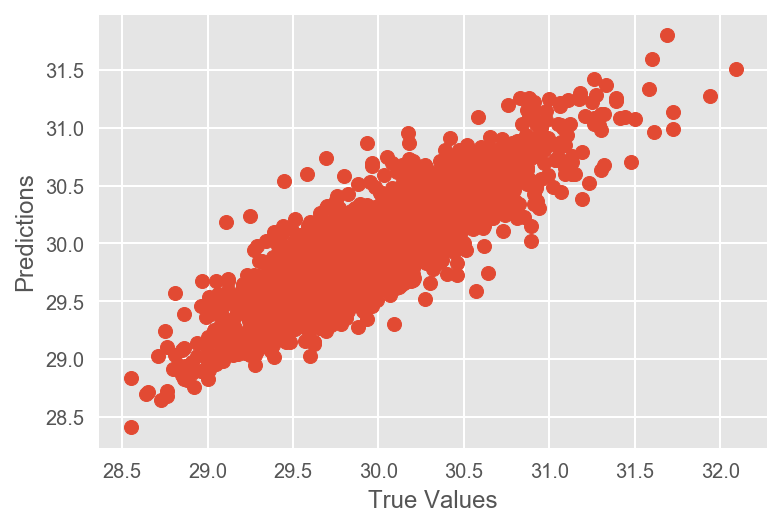

In [313]:
plt.scatter(dogs_under_40.time.values, dogs_under_40.predicted_time.values)
#plt.plot(np.linspace(0,50,200),np.linspace(0,50,200),c='r',lw=2)
plt.xlabel("True Values")
plt.ylabel("Predictions")

A nice linear realtionship exists in normal values

In [ ]:
nice_view = ['race_id', 'date_time', 'name', 'track', 'grade', 'time', 'predicted_time', 'winner', 'position']

In [315]:
dogs_under_40 = dogs_under_40[nice_view]
dogs_under_40.head()

,race_id,date_time,name,track,grade,time,predicted_time,winner,position
25924,1935168.0,2016-12-02 10:38:00,Drunk In Love,Swindon,A8,30.39,30.486663,0,6.0
25925,1935168.0,2016-12-02 10:38:00,Roseville Power,Swindon,A8,30.31,30.175313,0,5.0
25926,1935168.0,2016-12-02 10:38:00,Peaky Blinder,Swindon,A8,30.21,30.397725,0,4.0
25927,1935168.0,2016-12-02 10:38:00,Finnery Ace,Swindon,A8,30.15,30.118962,0,3.0
25928,1935168.0,2016-12-02 10:38:00,Clonleigh Kate,Swindon,A8,29.79,30.113097,0,2.0


In [318]:
# Make Series column
pred_pos = pd.Series()
for race in dogs_under_40.race_id.unique():
    pred_pos = pred_pos.append(predict_pos(race, dogs_under_40))

/Users/danielpayne/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [321]:
dogs_under_40['pred_position'] = pred_pos
dogs_under_40['pred_winner'] = dogs_under_40.pred_position.map(lambda x: 1 if x == 1 else 0)
dogs_under_40.head()

,race_id,date_time,name,track,grade,time,predicted_time,winner,position,pred_position,pred_winner
25924,1935168.0,2016-12-02 10:38:00,Drunk In Love,Swindon,A8,30.39,30.486663,0,6.0,6.0,0
25925,1935168.0,2016-12-02 10:38:00,Roseville Power,Swindon,A8,30.31,30.175313,0,5.0,4.0,0
25926,1935168.0,2016-12-02 10:38:00,Peaky Blinder,Swindon,A8,30.21,30.397725,0,4.0,5.0,0
25927,1935168.0,2016-12-02 10:38:00,Finnery Ace,Swindon,A8,30.15,30.118962,0,3.0,3.0,0
25928,1935168.0,2016-12-02 10:38:00,Clonleigh Kate,Swindon,A8,29.79,30.113097,0,2.0,2.0,0


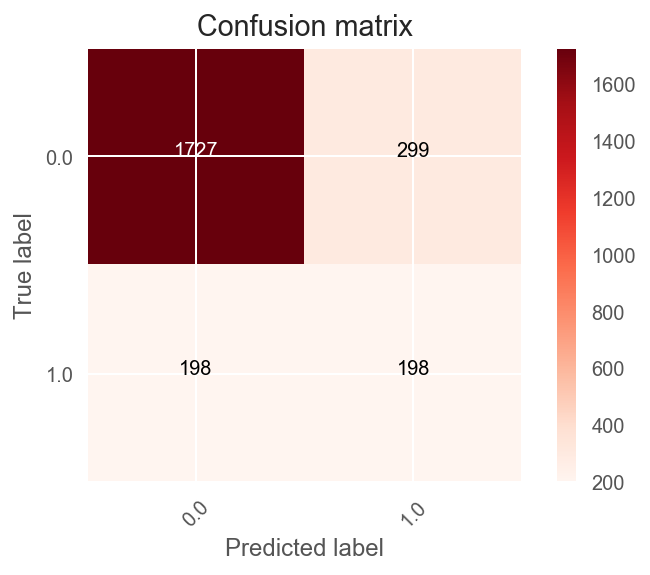

In [322]:
from sklearn import metrics
conmat = metrics.confusion_matrix(dogs_under_40.winner.values, dogs_under_40.pred_winner.values)
classes = np.array([ 0.,  1.])
plot_confusion_matrix(conmat, classes)

In [325]:
class_report = metrics.classification_report(dogs_under_40.winner.values, dogs_under_40.pred_winner.values)
print class_report

             precision    recall  f1-score   support

          0       0.90      0.85      0.87      2026
          1       0.40      0.50      0.44       396

avg / total       0.82      0.79      0.80      2422



In [328]:
lm_1_score = metrics.accuracy_score(dogs_under_40.winner.values, dogs_under_40.pred_winner.values)
print 'Original Model Score:\t\t', lm_vanilla_score
print 'New Model Score: \t\t', lm_1_score

Original Model Score:		0.740026595745
New Model Score: 		0.794797687861


# Assessment

This is an encouraging result. 

I am now getting very close to the baseline with my new model.

There will be opportunites to tune this model.  With more time I can get some more historical data so the mean times in my dataset will not have to be imputed.  This should yield some decent results. 